In [1]:
#imports
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import pickle

In [2]:
nltk.download('stopwords')
ps = PorterStemmer()
all_stopwords = stopwords.words('english')

if 'not' in all_stopwords:
    all_stopwords.remove('not')
stop_words_set = set(all_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # remove html
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower().split()
    # Stemming map
    text = [ps.stem(word) for word in text if word not in stop_words_set]
    return ' '.join(text)

In [28]:
print("Loading and cleaning data...")
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_data = dataset['train'].shuffle(25000)

corpus = []
y = []


for text_tensor, label_tensor in train_data.take(25000):
    raw_text = text_tensor.numpy().decode('utf-8')
    label = label_tensor.numpy()
    corpus.append(clean_text(raw_text))
    y.append(label)

y = np.array(y)

Loading and cleaning data...


In [5]:
vocab_size = 20000
max_length = 200
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='pre', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)

In [30]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(max_length,)),

    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64, mask_zero=True),

    tf.keras.layers.LSTM(64, dropout=0.5, recurrent_dropout=0.0),

    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

print("Training Stable Model...")
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_test, y_test)
)
model.save('sentiment_model.keras')
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 200, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,315,137 (5.02 MB)

 Trainable params: 1,315,137 (5.02 MB)

 Non-trainable params: 0 (0.00 B)

Training Stable Model...
Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 89s 137ms/step - accuracy: 0.6942 - loss: 0.5412 - val_accuracy: 0.8846 - val_loss: 0.2878
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 94s 150ms/step - accuracy: 0.9190 - loss: 0.2155 - val_accuracy: 0.8868 - val_loss: 0.2875
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 134s 138ms/step - accuracy: 0.9429 - loss: 0.1667 - val_accuracy: 0.8762 - val_loss: 0.3128
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 145ms/step - accuracy: 0.9537 - loss: 0.1341 - val_accuracy: 0.8870 - val_loss: 0.3410
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.9652 - loss: 0.1016 - val_accuracy: 0.8750 - val_loss: 0.3500
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 87s 138ms/step - accuracy: 0.9746 - loss: 0.0784 - val_accuracy: 0.8778 - val_loss: 0.4193
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 136ms/step - accuracy: 0.9785 - loss: 0.0676 - val_accuracy: 0.8724 - val_loss: 0.3937
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 136ms/step 

In [31]:


def predict_lstm(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_length, padding='pre', truncating='post')
    prediction = model.predict(padded)[0][0]
    label = "positive" if prediction > 0.5 else "negative"
    confidence = prediction if prediction > 0.5 else 1 - prediction
    return f"{label} ({confidence:.2%})"



In [32]:
print("I hate this movie:       ", predict_lstm("I hate this movie"))
print("I absolutely loved it:   ", predict_lstm("I absolutely loved it"))
print("The movie was good:  ", predict_lstm("The movie was good"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
I hate this movie:        negative (54.25%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
I absolutely loved it:    positive (86.06%)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
The movie was good:   positive (78.03%)


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


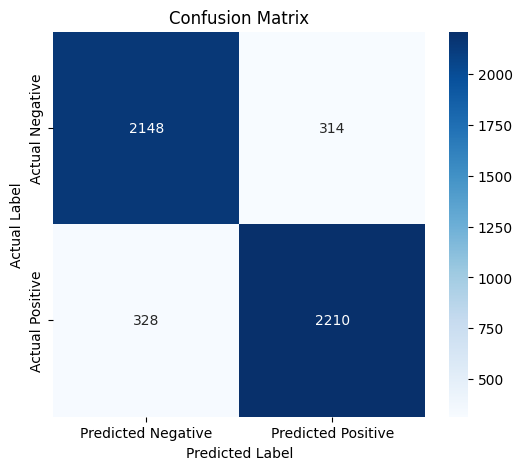

[[2148  314]
 [ 328 2210]]


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


y_pred_raw = model.predict(X_test)
y_pred = (y_pred_raw > 0.5).astype(int)


cm = confusion_matrix(y_test, y_pred)

#plot matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

print(cm)

In [34]:
from sklearn.metrics import accuracy_score, classification_report

#accuracy number
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc:.2%}")

print("\n--- Detailed Report ---")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Model Accuracy: 87.16%

--- Detailed Report ---
              precision    recall  f1-score   support

    Negative       0.87      0.87      0.87      2462
    Positive       0.88      0.87      0.87      2538

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000

